# **Task 4: Modality Gap in CLIP**

# **Part 1:**

In [ ]:
!pip install torch torchvision git+https://github.com/openai/CLIP.git matplotlib scikit-learn scipy umap-learn

In [ ]:
import torch
import clip
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1. Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 2. Download and Load STL-10
# STL-10 has 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck
dataset = STL10(root="./data", split="test", download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Get class names
class_names = dataset.classes
print(f"Classes: {class_names}")

# 3. Define Prompting Strategies
templates = {
    "Plain labels": lambda c: f"{c}",
    "Prompted text": lambda c: f"a photo of a {c}",
    "Descriptive": lambda c: f"a photo of a {c}, a type of object or animal"
}

def evaluate_accuracy(model, dataloader, prompt_func, class_names):
    model.eval()

    # Pre-compute text features to save time
    prompts = [prompt_func(c) for c in class_names]
    text_inputs = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True) # Normalize

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Eval: {prompt_func('cat')}"):
            images = images.to(device)
            labels = labels.to(device)

            # Get image features
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # Calculate similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity.topk(1)

            correct += indices.view(-1).eq(labels).sum().item()
            total += labels.size(0)

    return correct / total

# Execute Comparison
results = {}
for name, func in templates.items():
    acc = evaluate_accuracy(model, dataloader, func, class_names)
    results[name] = acc
    print(f"Strategy: '{name}' | Accuracy: {acc:.4f}")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 244MiB/s]
100%|██████████| 2.64G/2.64G [03:52<00:00, 11.4MB/s]


Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


Eval: cat: 100%|██████████| 250/250 [20:47<00:00,  4.99s/it]


Strategy: 'Plain labels' | Accuracy: 0.9625


Eval: a photo of a cat: 100%|██████████| 250/250 [20:53<00:00,  5.01s/it]


Strategy: 'Prompted text' | Accuracy: 0.9736


Eval: a photo of a cat, a type of object or animal: 100%|██████████| 250/250 [20:57<00:00,  5.03s/it]

Strategy: 'Descriptive' | Accuracy: 0.9749


# **Part 2**

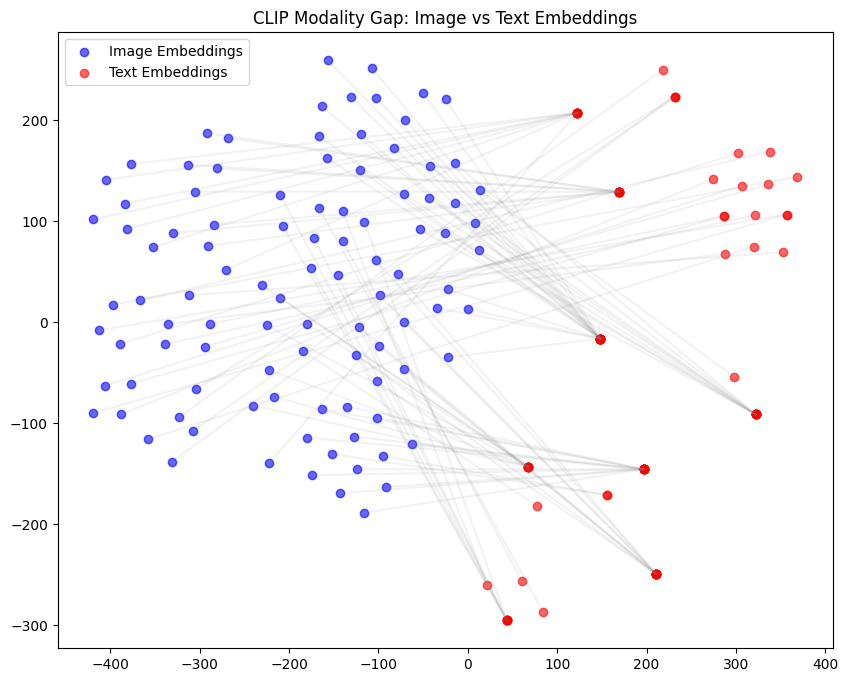

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_modality_gap():
    # Take a subset (first 100 images)
    subset_loader = DataLoader(dataset, batch_size=100, shuffle=False)
    images, labels = next(iter(subset_loader))
    images = images.to(device)

    # Generate Prompted Text for these specific labels
    # We pair the image with its CORRECT text label
    text_prompts = [f"a photo of a {class_names[l]}" for l in labels]
    text_inputs = clip.tokenize(text_prompts).to(device)

    with torch.no_grad():
        # Encode
        img_emb = model.encode_image(images)
        txt_emb = model.encode_text(text_inputs)

        # Normalize (Crucial for cosine similarity, but we want to see the gap)
        img_emb /= img_emb.norm(dim=-1, keepdim=True)
        txt_emb /= txt_emb.norm(dim=-1, keepdim=True)

    # Move to CPU for sklearn
    img_emb_np = img_emb.cpu().numpy()
    txt_emb_np = txt_emb.cpu().numpy()

    # Concatenate for t-SNE
    combined = np.concatenate([img_emb_np, txt_emb_np], axis=0)

    # Reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(combined)

    # Split back
    img_2d = reduced[:100]
    txt_2d = reduced[100:]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(img_2d[:, 0], img_2d[:, 1], c='blue', label='Image Embeddings', alpha=0.6)
    plt.scatter(txt_2d[:, 0], txt_2d[:, 1], c='red', label='Text Embeddings', alpha=0.6)

    # Draw lines connecting pairs to see alignment
    for i in range(100):
        plt.plot([img_2d[i, 0], txt_2d[i, 0]], [img_2d[i, 1], txt_2d[i, 1]], 'gray', alpha=0.1)

    plt.legend()
    plt.title("CLIP Modality Gap: Image vs Text Embeddings")
    plt.show()

visualize_modality_gap()

# **Part 3**

Extracting features for alignment...


100%|██████████| 8/8 [41:03<00:00, 307.89s/it]


Calculating Procrustes Rotation...
Original Mean Squared Error: 0.002868
Aligned Mean Squared Error:  0.000543
Generating visualizations...


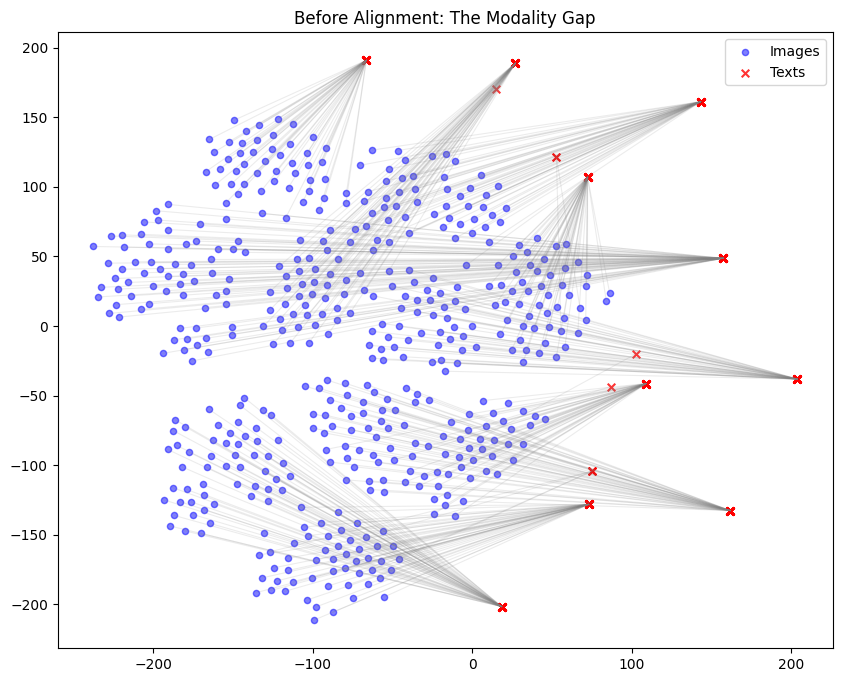

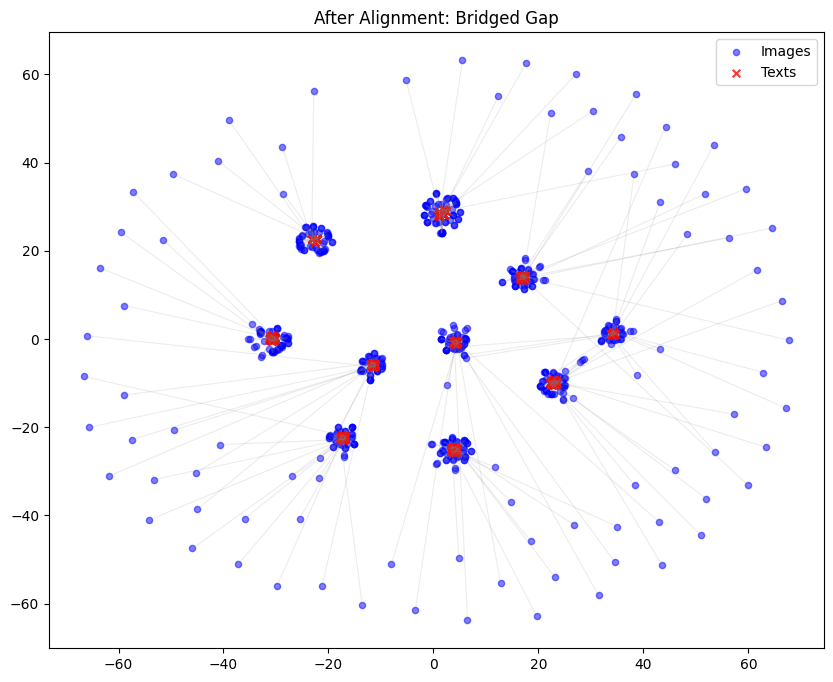

Recomputing Accuracy with Aligned Embeddings...
Zero-Shot Accuracy (Post-Alignment): 0.9794


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
import clip
from tqdm import tqdm

# --- Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# Load Data (using a subset for faster visualization/computation if needed, but here we use full test)
dataset = STL10(root="./data", split="test", download=True, transform=preprocess)
# We use a larger batch for the Procrustes calculation to get a stable rotation matrix
dataloader = DataLoader(dataset, batch_size=1000, shuffle=False)

class_names = dataset.classes

# --- Step (b): Pair Image and Text Embeddings ---
# We need matrices X (Images) and Y (Texts) such that row i of X corresponds to row i of Y.

all_img_feats = []
all_txt_feats = []
all_labels = []

print("Extracting features for alignment...")
with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)

        # 1. Encode Images
        img_emb = model.encode_image(images)
        img_emb /= img_emb.norm(dim=-1, keepdim=True) # Normalize

        # 2. Encode Texts (Use the Ground Truth label for pairing)
        # We use the "Prompted text" strategy from Part 1 as the anchor
        prompts = [f"a photo of a {class_names[l]}" for l in labels]
        txt_inputs = clip.tokenize(prompts).to(device)
        txt_emb = model.encode_text(txt_inputs)
        txt_emb /= txt_emb.norm(dim=-1, keepdim=True) # Normalize

        all_img_feats.append(img_emb.cpu().numpy())
        all_txt_feats.append(txt_emb.cpu().numpy())
        all_labels.extend(labels.numpy())

# Concatenate all batches
X = np.concatenate(all_img_feats, axis=0) # Image Embeddings (N, 512)
Y = np.concatenate(all_txt_feats, axis=0) # Text Embeddings (N, 512)

# --- Step (c): Learn Optimal Rotation Matrix R ---
# We want R such that ||XR - Y|| is minimized.
# scipy.linalg.orthogonal_procrustes(A, B) minimizes ||A @ R - B||.
print("Calculating Procrustes Rotation...")
R, scale = orthogonal_procrustes(X, Y)

# --- Step (d): Apply Rotation Transform ---
X_aligned = X @ R

print(f"Original Mean Squared Error: {np.mean(np.square(X - Y)):.6f}")
print(f"Aligned Mean Squared Error:  {np.mean(np.square(X_aligned - Y)):.6f}")

# --- Step (e): Visualize with t-SNE ---
def plot_embeddings(img_emb, txt_emb, title, num_points=500):
    """Helper to plot a subset of embeddings"""
    # Subset for clearer visualization
    img_subset = img_emb[:num_points]
    txt_subset = txt_emb[:num_points]

    # Combine for t-SNE
    combined = np.concatenate([img_subset, txt_subset], axis=0)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(combined)

    # Split back
    img_2d = reduced[:num_points]
    txt_2d = reduced[num_points:]

    plt.figure(figsize=(10, 8))
    # Plot Images as Blue dots
    plt.scatter(img_2d[:, 0], img_2d[:, 1], c='blue', label='Images', alpha=0.5, s=20)
    # Plot Texts as Red xs
    plt.scatter(txt_2d[:, 0], txt_2d[:, 1], c='red', label='Texts', marker='x', alpha=0.8, s=30)

    # Draw gray lines connecting the pairs
    for i in range(num_points):
        plt.plot([img_2d[i, 0], txt_2d[i, 0]], [img_2d[i, 1], txt_2d[i, 1]],
                 c='gray', alpha=0.15, linewidth=0.8)

    plt.legend()
    plt.title(title)
    plt.show()

print("Generating visualizations...")
# 1. Before Alignment
plot_embeddings(X, Y, "Before Alignment: The Modality Gap")

# 2. After Alignment
plot_embeddings(X_aligned, Y, "After Alignment: Bridged Gap")


# --- Step (f): Recompute Classification Accuracy ---
print("Recomputing Accuracy with Aligned Embeddings...")

# 1. Prepare Candidate Text Embeddings (The 10 classes)
# We must NOT rotate these. We rotated images TO the text space.
text_prompts = [f"a photo of a {c}" for c in class_names]
text_inputs = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    class_embeddings = model.encode_text(text_inputs)
    class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
    class_embeddings = class_embeddings.cpu().numpy()

# 2. Compute Accuracy
# Logits = Image_Aligned @ Class_Embeddings.T
# shape: (N, 512) @ (10, 512).T -> (N, 10)
logits = X_aligned @ class_embeddings.T
predictions = np.argmax(logits, axis=1)
ground_truth = np.array(all_labels)

accuracy = np.mean(predictions == ground_truth)
print(f"Zero-Shot Accuracy (Post-Alignment): {accuracy:.4f}")